# Исследование по GMTS

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [112]:
# Загрузка 5 минутных данных
df = pd.read_csv('df_m5_TVI_CCI_T3_GHL.csv')
df['tradedate'] = pd.to_datetime(df['tradedate'])

df

,tradedate,open,high,low,close,tvi,cci,t3,ghl
0,2015-01-05 10:00:00,142000.0,143900.0,140200.0,140900.0,0,0,0,0
1,2015-01-05 10:05:00,140700.0,141000.0,138525.0,140600.0,1,0,-1,0
2,2015-01-05 10:10:00,140300.0,141000.0,140200.0,140650.0,1,0,-1,0
3,2015-01-05 10:15:00,140200.0,141050.0,140200.0,141050.0,1,0,-1,0
4,2015-01-05 10:20:00,141000.0,141500.0,140825.0,140900.0,1,0,1,0
...,...,...,...,...,...,...,...,...,...
407824,2024-12-30 23:25:00,301125.0,301350.0,300400.0,300450.0,1,1,1,0
407825,2024-12-30 23:30:00,300450.0,300525.0,300400.0,300500.0,-1,1,1,0
407826,2024-12-30 23:35:00,300450.0,300450.0,300275.0,300425.0,-1,1,-1,0
407827,2024-12-30 23:40:00,300450.0,300750.0,300425.0,300700.0,-1,1,-1,0


Создание дата фрейма с колонкой **'buy_sell'** признаков открытия позиции Bay или Sell.

In [113]:
# Проверка, являются ли все значения в строке одинаковыми [1, 1, 1, 1] или [-1, -1, -1, -1]
df['IsAllSame'] = df[['tvi', 'cci', 't3', 'ghl']].eq(1).all(axis=1) | \
    df[['tvi', 'cci', 't3', 'ghl']].eq(-1).all(axis=1)

# Находим группы последовательных строк, где IsAllSame == True
df['Group'] = (df['IsAllSame'] != df['IsAllSame'].shift(1)).cumsum()

# Отмечаем только вторую строку в каждой группе, где IsAllSame == True
df['SecondInRow'] = df.groupby('Group').cumcount() == 1
df.loc[~df['IsAllSame'], 'SecondInRow'] = False  # Убираем строки, где IsAllSame == False

# Добавляем колонку 'sig', отмечаем только вторую строку в последовательности
df['sig'] = 0
df.loc[df['SecondInRow'], 'sig'] = 1

# Убираем вспомогательную колонку 'Group', 'IsAllSame', 'SecondInRow'
df.drop(columns=['Group', 'IsAllSame', 'SecondInRow'], inplace=True)

# Добавляем колонку с ценой открытия по сигналу
df['sig_open'] = df.apply(lambda x: x.open if x.sig == 1 else 0, axis=1)

# Добавляем колонку с направлением торговли
conditions = [
    (df['tvi'] == 1) & (df['cci'] == 1) & (df['t3'] == 1) & (df['ghl'] == 1) & (df['sig'] == 1),
    (df['tvi'] == -1) & (df['cci'] == -1) & (df['t3'] == -1) & (df['ghl'] == -1) & (df['sig'] == 1)
]
choices = [1, -1]
df['buy_sell'] = np.select(conditions, choices, default=0)

df

,tradedate,open,high,low,close,tvi,cci,t3,ghl,sig,sig_open,buy_sell
0,2015-01-05 10:00:00,142000.0,143900.0,140200.0,140900.0,0,0,0,0,0,0.0,0
1,2015-01-05 10:05:00,140700.0,141000.0,138525.0,140600.0,1,0,-1,0,0,0.0,0
2,2015-01-05 10:10:00,140300.0,141000.0,140200.0,140650.0,1,0,-1,0,0,0.0,0
3,2015-01-05 10:15:00,140200.0,141050.0,140200.0,141050.0,1,0,-1,0,0,0.0,0
4,2015-01-05 10:20:00,141000.0,141500.0,140825.0,140900.0,1,0,1,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
407824,2024-12-30 23:25:00,301125.0,301350.0,300400.0,300450.0,1,1,1,0,0,0.0,0
407825,2024-12-30 23:30:00,300450.0,300525.0,300400.0,300500.0,-1,1,1,0,0,0.0,0
407826,2024-12-30 23:35:00,300450.0,300450.0,300275.0,300425.0,-1,1,-1,0,0,0.0,0
407827,2024-12-30 23:40:00,300450.0,300750.0,300425.0,300700.0,-1,1,-1,0,0,0.0,0


Создаем колонку **"profit"** в которую записываем:  
если значение в колонке 'buy_sell' равно 1, то из ближайшего последующего значения в колонке 'sig_open' не равного 0, вычесть текущее значение в колонке 'sig_open'  
если значение в колонке 'buy_sell' равно -1, то из текущего значения в колонке 'sig_open', вычесть ближайшее последующее значение в колонке 'sig_open' не равное 0  
иначе, записать в колонку 0

In [114]:
def calculate_profit(row, sig_open_col, buy_sell_col):
    # Индекс текущей строки
    current_index = row.name

    # Значение buy_sell для текущей строки
    buy_sell = row[buy_sell_col]
    sig_open = row[sig_open_col]

    # Если buy_sell равно 1
    if buy_sell == 1:
        # Найти ближайшее последующее значение в sig_open, не равное 0
        for next_value in df.loc[current_index + 1:, sig_open_col]:
            if next_value != 0:
                return next_value - sig_open

    # Если buy_sell равно -1
    elif buy_sell == -1:
        # Найти ближайшее последующее значение в sig_open, не равное 0
        for next_value in df.loc[current_index + 1:, sig_open_col]:
            if next_value != 0:
                return sig_open - next_value

    # Если buy_sell не равно 1 или -1
    return 0

# Применить функцию ко всем строкам
df['profit'] = df.apply(calculate_profit, axis=1, sig_open_col='sig_open', buy_sell_col='buy_sell')

# Результат
df

,tradedate,open,high,low,close,tvi,cci,t3,ghl,sig,sig_open,buy_sell,profit
0,2015-01-05 10:00:00,142000.0,143900.0,140200.0,140900.0,0,0,0,0,0,0.0,0,0.0
1,2015-01-05 10:05:00,140700.0,141000.0,138525.0,140600.0,1,0,-1,0,0,0.0,0,0.0
2,2015-01-05 10:10:00,140300.0,141000.0,140200.0,140650.0,1,0,-1,0,0,0.0,0,0.0
3,2015-01-05 10:15:00,140200.0,141050.0,140200.0,141050.0,1,0,-1,0,0,0.0,0,0.0
4,2015-01-05 10:20:00,141000.0,141500.0,140825.0,140900.0,1,0,1,0,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
407824,2024-12-30 23:25:00,301125.0,301350.0,300400.0,300450.0,1,1,1,0,0,0.0,0,0.0
407825,2024-12-30 23:30:00,300450.0,300525.0,300400.0,300500.0,-1,1,1,0,0,0.0,0,0.0
407826,2024-12-30 23:35:00,300450.0,300450.0,300275.0,300425.0,-1,1,-1,0,0,0.0,0,0.0
407827,2024-12-30 23:40:00,300450.0,300750.0,300425.0,300700.0,-1,1,-1,0,0,0.0,0,0.0


Фильтрация

In [115]:
# Очистка df
df = df[df["profit"] != 0.0]

# Фильтрация строк с марта 2015 и времени до 19:00:00
df = df[
    (df["tradedate"] >= pd.Timestamp("2015-03-01")) & 
    (df["tradedate"].dt.time < pd.to_datetime("19:00:00").time())
]

df = df.copy().reset_index(drop=True)

# Добавление колонки с датой
df['date'] = df['tradedate'].dt.date

# Добавление колонки с временем
df['time'] = df['tradedate'].dt.time

# Учет спреда при симуляции торговли
df["profit"] = df["profit"] - 25

df

,tradedate,open,high,low,close,tvi,cci,t3,ghl,sig,sig_open,buy_sell,profit,date,time
0,2015-03-02 10:05:00,177975.0,178150.0,177975.0,178025.0,-1,-1,-1,-1,1,177975.0,-1,-400.0,2015-03-02,10:05:00
1,2015-03-02 10:50:00,178350.0,178550.0,178350.0,178550.0,1,1,1,1,1,178350.0,1,925.0,2015-03-02,10:50:00
2,2015-03-02 12:20:00,179300.0,179450.0,179200.0,179325.0,-1,-1,-1,-1,1,179300.0,-1,100.0,2015-03-02,12:20:00
3,2015-03-02 12:35:00,179175.0,179200.0,178950.0,179075.0,-1,-1,-1,-1,1,179175.0,-1,0.0,2015-03-02,12:35:00
4,2015-03-02 13:00:00,179150.0,179200.0,179100.0,179100.0,-1,-1,-1,-1,1,179150.0,-1,200.0,2015-03-02,13:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23535,2024-12-30 15:05:00,299800.0,299825.0,299350.0,299600.0,1,1,1,1,1,299800.0,1,-1775.0,2024-12-30,15:05:00
23536,2024-12-30 15:40:00,298050.0,298525.0,297875.0,298425.0,-1,-1,-1,-1,1,298050.0,-1,-550.0,2024-12-30,15:40:00
23537,2024-12-30 15:55:00,298575.0,298675.0,298100.0,298100.0,-1,-1,-1,-1,1,298575.0,-1,-300.0,2024-12-30,15:55:00
23538,2024-12-30 17:05:00,298850.0,299225.0,298850.0,298900.0,1,1,1,1,1,298850.0,1,-175.0,2024-12-30,17:05:00


Создание DF с профитом по времени открытия сделок.

In [116]:
df_time = (
    df.groupby(['time'], as_index=False)
    .agg(
        total_profit=('profit', 'sum'),  # Сумма значений profit
        count_profit=('profit', 'count')  # Количество значений profit
    )
    .sort_values(['total_profit'], ascending=False)
)

df_time['profit_avg'] = df_time['total_profit'] / df_time['count_profit']

df_time['profit_avg'] = df_time['profit_avg'].round(2)

print(df_time.sort_values (by='profit_avg', ascending=False).head(20))
print(f'Средний профит: {df_time['profit_avg'].mean()}')

         time  total_profit  count_profit  profit_avg
0    07:00:00       23325.0            34      686.03
36   10:00:00      132475.0           272      487.04
7    07:35:00        3125.0             7      446.43
24   09:00:00       25800.0            73      353.42
35   09:55:00       16275.0            50      325.50
23   08:55:00        6000.0            19      315.79
126  17:30:00       63575.0           219      290.30
15   08:15:00        5000.0            19      263.16
50   11:10:00       58350.0           247      236.23
48   11:00:00       40050.0           184      217.66
59   11:55:00       45100.0           208      216.83
125  17:25:00       38425.0           189      203.31
85   14:05:00       36225.0           179      202.37
38   10:10:00       51200.0           269      190.33
37   10:05:00       90100.0           497      181.29
41   10:25:00       31225.0           180      173.47
26   09:10:00       13200.0            77      171.43
128  17:40:00       34225.0 

In [117]:
# Сохранение в файл
df_time.sort_values(by='time', ascending=True).to_excel('MIX_исследования_времени_торговли.xlsx')

Создание графика со средними значениями профита

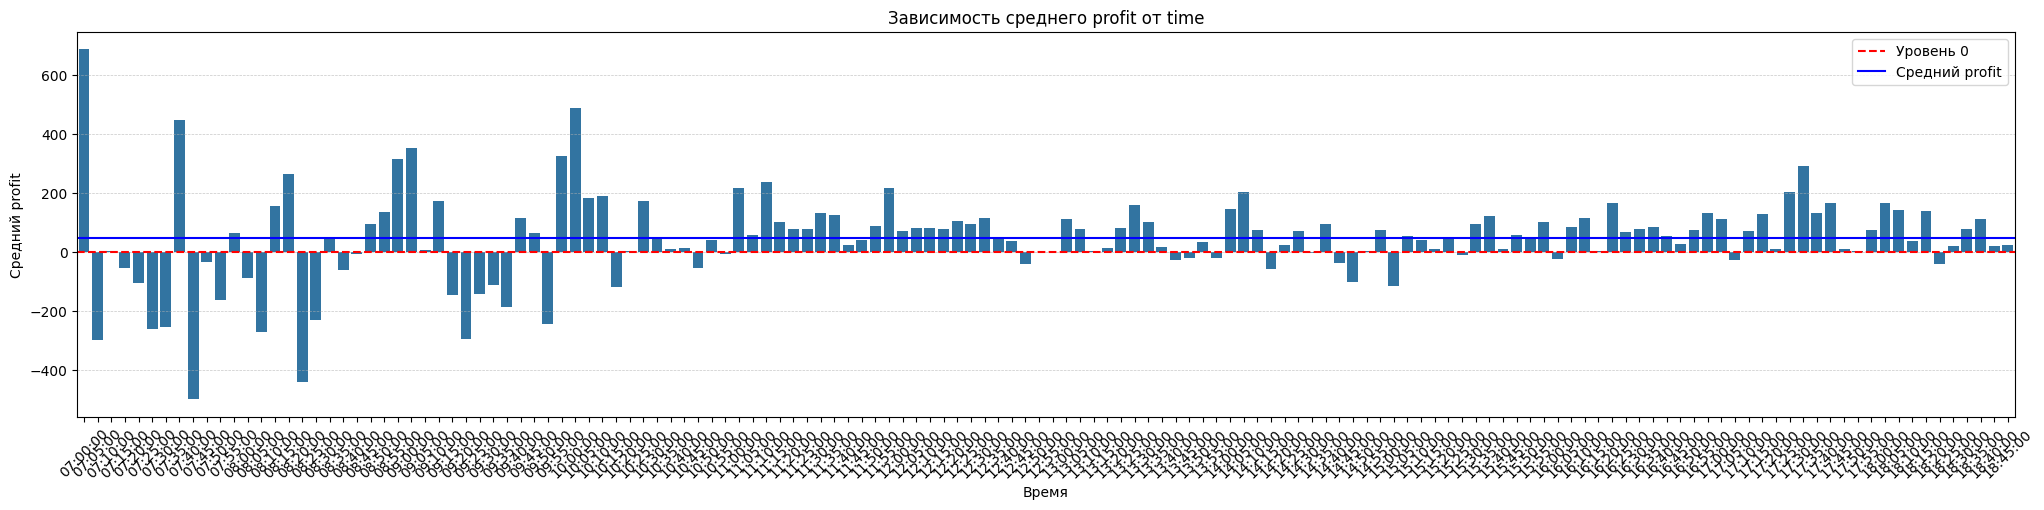

In [118]:
df_time = df_time.sort_values(by='time', ascending=True)

# Строим график зависимости
plt.figure(figsize=(25, 5))
sns.barplot(x=df_time['time'].astype(str), y=df_time['profit_avg'])

# Добавляем горизонтальные линии
plt.axhline(
    y=0, color='red', linestyle='--', linewidth=1.5, label='Уровень 0'
    )  # Пример линии на уровне 0
plt.axhline(
    y=df_time['profit_avg'].mean(), color='blue', linestyle='-', linewidth=1.5, 
    label='Средний profit'
    )  # Среднее значение

# Добавляем горизонтальную сетку
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)  # Только по оси Y

plt.xticks(rotation=45)  # Поворачиваем подписи оси X для читаемости
plt.title('Зависимость среднего profit от time')
plt.xlabel('Время')
plt.ylabel('Средний profit')
plt.legend()  # Добавляем легенду
plt.show()

### Прибыль по сделкам за 15:30-18:20

In [119]:
# Фильтрация строк с 15:15:00
df_amer = df[
         (df["tradedate"].dt.time >= pd.to_datetime("15:30:00").time()) & 
         (df["tradedate"].dt.time <= pd.to_datetime("18:35:00").time())
]

df_amer

,tradedate,open,high,low,close,tvi,cci,t3,ghl,sig,sig_open,buy_sell,profit,date,time
7,2015-03-02 15:45:00,178625.0,178875.0,178625.0,178725.0,1,1,1,1,1,178625.0,1,-75.0,2015-03-02,15:45:00
8,2015-03-02 16:05:00,178575.0,178575.0,178525.0,178550.0,1,1,1,1,1,178575.0,1,0.0,2015-03-02,16:05:00
9,2015-03-02 16:20:00,178600.0,178925.0,178575.0,178900.0,1,1,1,1,1,178600.0,1,75.0,2015-03-02,16:20:00
10,2015-03-02 18:35:00,178700.0,178700.0,178250.0,178600.0,-1,-1,-1,-1,1,178700.0,-1,625.0,2015-03-02,18:35:00
15,2015-03-03 15:40:00,182200.0,182200.0,182050.0,182050.0,-1,-1,-1,-1,1,182200.0,-1,75.0,2015-03-03,15:40:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23529,2024-12-28 18:25:00,290350.0,290525.0,290300.0,290475.0,1,1,1,1,1,290350.0,1,475.0,2024-12-28,18:25:00
23536,2024-12-30 15:40:00,298050.0,298525.0,297875.0,298425.0,-1,-1,-1,-1,1,298050.0,-1,-550.0,2024-12-30,15:40:00
23537,2024-12-30 15:55:00,298575.0,298675.0,298100.0,298100.0,-1,-1,-1,-1,1,298575.0,-1,-300.0,2024-12-30,15:55:00
23538,2024-12-30 17:05:00,298850.0,299225.0,298850.0,298900.0,1,1,1,1,1,298850.0,1,-175.0,2024-12-30,17:05:00


### Прибыль по дням  за 15:30-18:35

In [120]:
df_amer_date = (
    df_amer.groupby(['date'], as_index=False)
    .agg(
        total_profit=('profit', 'sum'),  # Сумма значений profit
        count_trade=('profit', 'count')  # Количество значений profit
    )
    # .sort_values(['total_profit'], ascending=False)
)

# df_amer_date.sort_values(by='date', ascending=True).to_excel('GMTS_даты_торговли.xlsx')

df_amer_date

,date,total_profit,count_trade
0,2015-03-02,625.0,4
1,2015-03-03,-550.0,3
2,2015-03-04,1975.0,3
3,2015-03-05,1475.0,3
4,2015-03-06,-350.0,4
...,...,...,...
2452,2024-12-25,550.0,5
2453,2024-12-26,-600.0,3
2454,2024-12-27,-950.0,3
2455,2024-12-28,400.0,4


### Прибыль по месяцам за 15:30-18:35

In [121]:
df_tmp = df_amer.copy()

# Убедимся, что колонка с датой в формате datetime
df_tmp['date'] = pd.to_datetime(df_tmp['date'])

# Добавляем колонки для года и месяца
df_tmp['year_month'] = df_tmp['date'].dt.to_period('M')  # Год и месяц в формате YYYY-MM

# Группируем данные по году и месяцу
df_month_profit = (
    df_tmp.groupby('year_month')
    .agg(
        total_profit=('profit', 'sum'),    # Сумма прибыли за месяц
        total_trades=('profit', 'count')  # Количество сделок за месяц
    )
    .reset_index()
)

# # Если нужно, преобразуем 'year_month' обратно в строку
# month_profit['year_month'] = month_profit['year_month'].astype(str)

df_month_profit['dollar'] = df_month_profit['total_profit'] * 0.02

# df_month_profit.sort_values(by='year_month', ascending=True) \
#     .to_excel('GMTS_прибыль_месяца_15-19.xlsx', index=False)

df_month_profit

,year_month,total_profit,total_trades,dollar
0,2015-03,4275.0,61,85.5
1,2015-04,0.0,86,0.0
2,2015-05,4675.0,60,93.5
3,2015-06,7475.0,69,149.5
4,2015-07,4400.0,66,88.0
...,...,...,...,...
113,2024-08,7850.0,87,157.0
114,2024-09,29550.0,62,591.0
115,2024-10,5425.0,83,108.5
116,2024-11,14400.0,57,288.0


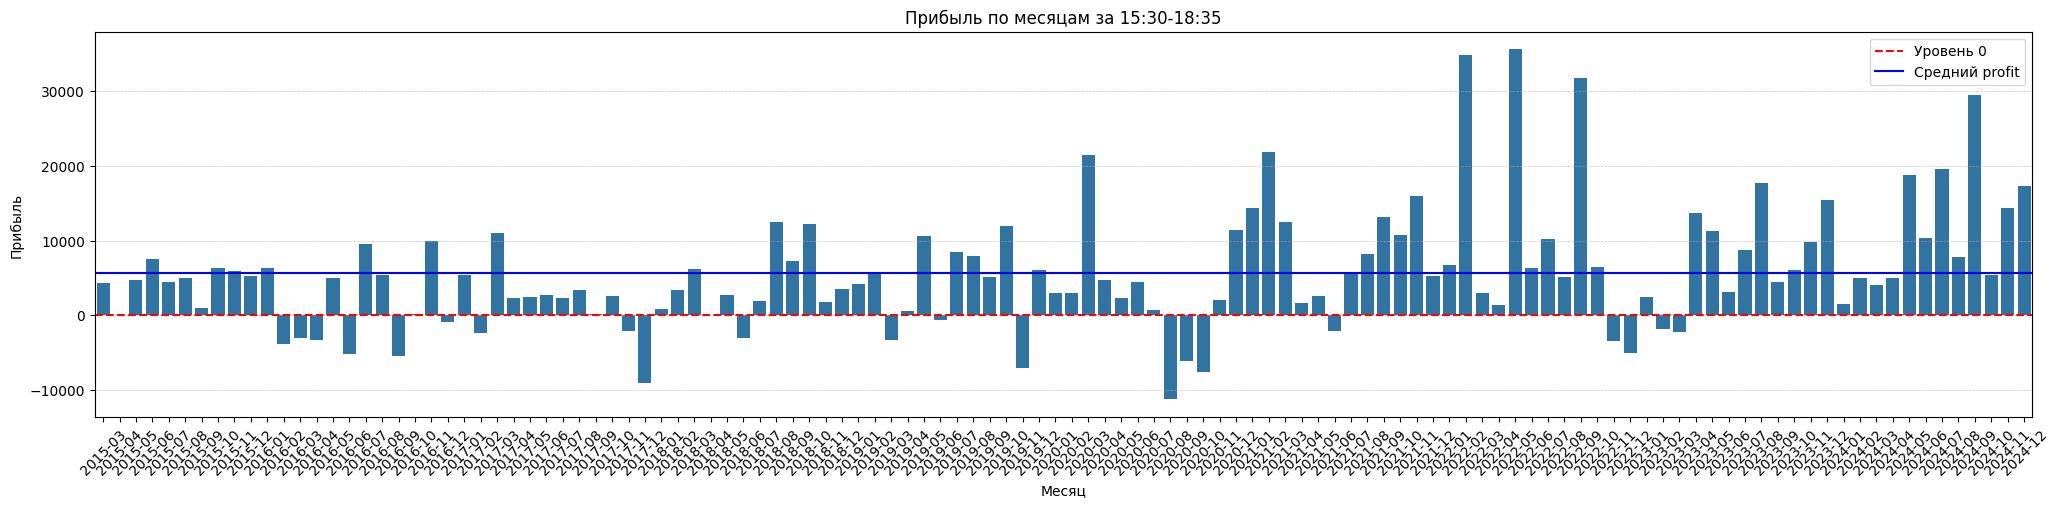

In [122]:
df_month_profit = df_month_profit.sort_values(by='year_month', ascending=True)

# Строим график зависимости
plt.figure(figsize=(25, 5))
sns.barplot(x=df_month_profit['year_month'].astype(str), y=df_month_profit['total_profit'])

# Добавляем горизонтальные линии
plt.axhline(
    y=0, color='red', linestyle='--', linewidth=1.5, label='Уровень 0'
    )  # Пример линии на уровне 0
plt.axhline(
    y=df_month_profit['total_profit'].mean(), color='blue', linestyle='-', linewidth=1.5, 
    label='Средний profit'
    )  # Среднее значение

# Добавляем горизонтальную сетку
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)  # Только по оси Y

plt.xticks(rotation=45)  # Поворачиваем подписи оси X для читаемости
plt.title('Прибыль по месяцам за 15:30-18:35')
plt.xlabel('Месяц')
plt.ylabel('Прибыль')
plt.legend()  # Добавляем легенду
plt.show()

### График комулятивной прибыли за 15:30-18:35

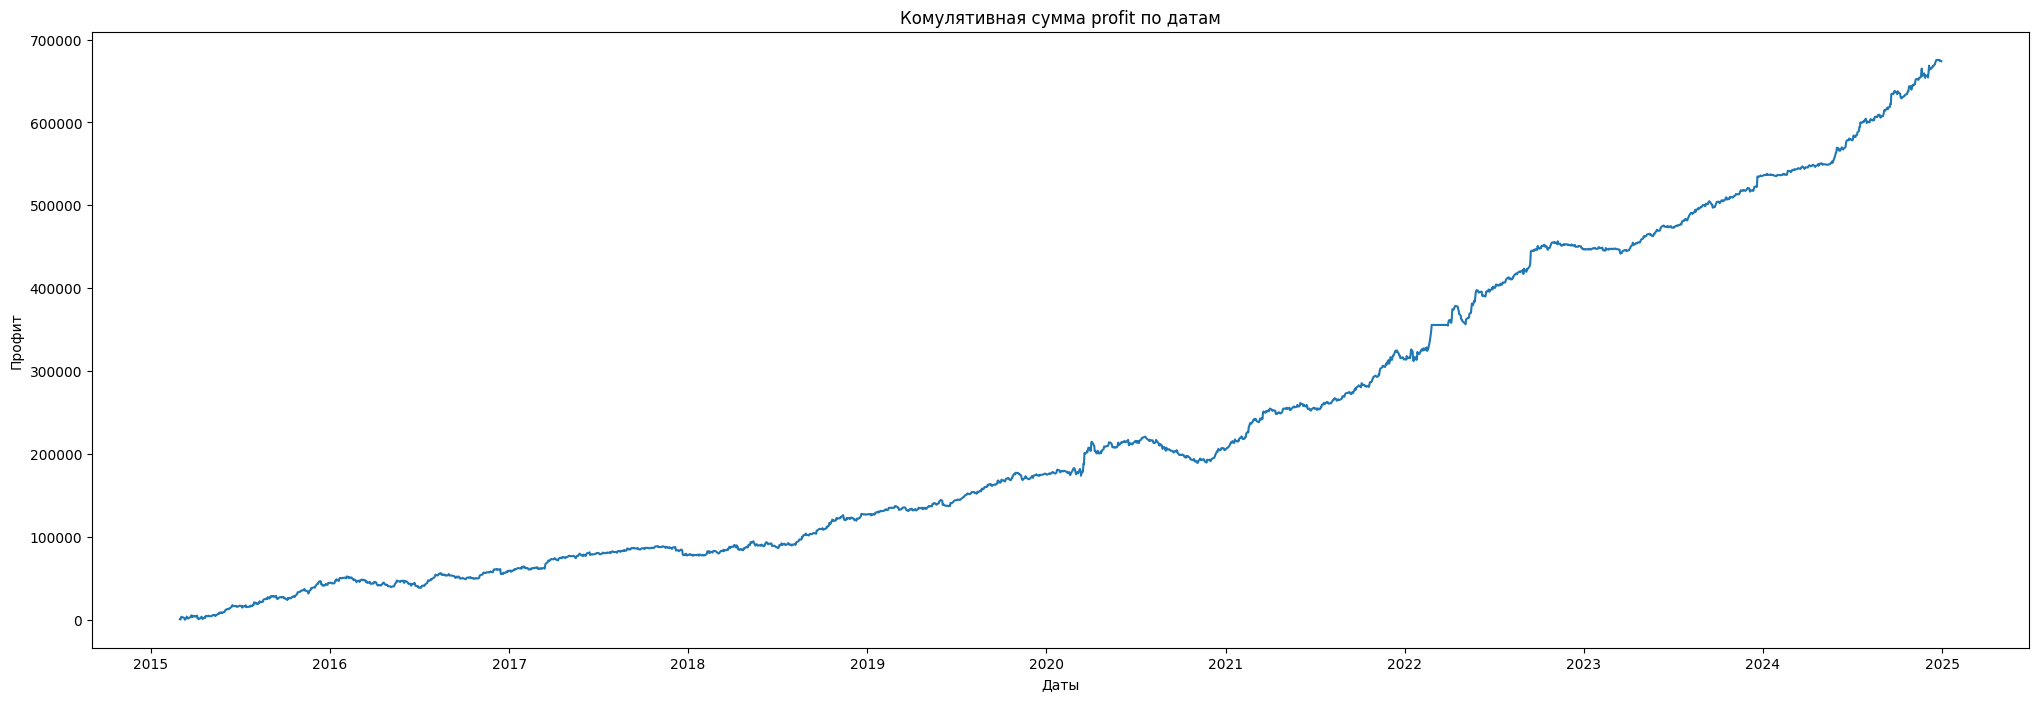

In [123]:
df_amer_date['sum_profit'] = df_amer_date['total_profit'].cumsum()

plt.figure(figsize=(25, 8))
sns.lineplot(data=df_amer_date, x=df_amer_date['date'], y='sum_profit')
plt.title('Комулятивная сумма profit по датам')
plt.xlabel('Даты')
plt.ylabel('Профит')
plt.show()



# Прибыль за две сессии 10:05-14:10 и 15:15-18:30

In [124]:
# Фильтрация строк
df_2 = df[
         (df["tradedate"].dt.time >= pd.to_datetime("10:05:00").time()) & 
         (df["tradedate"].dt.time <= pd.to_datetime("14:10:00").time()) |
         (df["tradedate"].dt.time >= pd.to_datetime("15:15:00").time()) & 
         (df["tradedate"].dt.time <= pd.to_datetime("18:30:00").time())
]

df_2

,tradedate,open,high,low,close,tvi,cci,t3,ghl,sig,sig_open,buy_sell,profit,date,time
0,2015-03-02 10:05:00,177975.0,178150.0,177975.0,178025.0,-1,-1,-1,-1,1,177975.0,-1,-400.0,2015-03-02,10:05:00
1,2015-03-02 10:50:00,178350.0,178550.0,178350.0,178550.0,1,1,1,1,1,178350.0,1,925.0,2015-03-02,10:50:00
2,2015-03-02 12:20:00,179300.0,179450.0,179200.0,179325.0,-1,-1,-1,-1,1,179300.0,-1,100.0,2015-03-02,12:20:00
3,2015-03-02 12:35:00,179175.0,179200.0,178950.0,179075.0,-1,-1,-1,-1,1,179175.0,-1,0.0,2015-03-02,12:35:00
4,2015-03-02 13:00:00,179150.0,179200.0,179100.0,179100.0,-1,-1,-1,-1,1,179150.0,-1,200.0,2015-03-02,13:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23534,2024-12-30 14:05:00,297350.0,297350.0,297000.0,297250.0,1,1,1,1,1,297350.0,1,2425.0,2024-12-30,14:05:00
23536,2024-12-30 15:40:00,298050.0,298525.0,297875.0,298425.0,-1,-1,-1,-1,1,298050.0,-1,-550.0,2024-12-30,15:40:00
23537,2024-12-30 15:55:00,298575.0,298675.0,298100.0,298100.0,-1,-1,-1,-1,1,298575.0,-1,-300.0,2024-12-30,15:55:00
23538,2024-12-30 17:05:00,298850.0,299225.0,298850.0,298900.0,1,1,1,1,1,298850.0,1,-175.0,2024-12-30,17:05:00


### Прибыль по дням за 2 сессии

In [125]:
df_2_date = (
    df_2.groupby(['date'], as_index=False)
    .agg(
        total_profit=('profit', 'sum'),  # Сумма значений profit
        count_trade=('profit', 'count')  # Количество значений profit
    )
    # .sort_values(['total_profit'], ascending=False)
)

# df_2_date.sort_values(by='date', ascending=True).to_excel('GMTS_даты_торговли.xlsx')

df_2_date

,date,total_profit,count_trade
0,2015-03-02,450.0,9
1,2015-03-03,-5000.0,5
2,2015-03-04,3025.0,6
3,2015-03-05,2125.0,8
4,2015-03-06,-350.0,8
...,...,...,...
2466,2024-12-25,3100.0,8
2467,2024-12-26,-925.0,7
2468,2024-12-27,-2375.0,9
2469,2024-12-28,3325.0,6


### Прибыль по месяцам за две сессии

In [126]:
df_tmp = df_tmp.iloc[0:0]
df_month_profit = df_month_profit.iloc[0:0]

df_tmp = df_2.copy()

# Убедимся, что колонка с датой в формате datetime
df_tmp['date'] = pd.to_datetime(df['date'])

# Добавляем колонки для года и месяца
df_tmp['year_month'] = df_tmp['date'].dt.to_period('M')  # Год и месяц в формате YYYY-MM

# Группируем данные по году и месяцу
df_month_profit = (
    df_tmp.groupby('year_month')
    .agg(
        total_profit=('profit', 'sum'),    # Сумма прибыли за месяц
        total_trades=('profit', 'count')  # Количество сделок за месяц
    )
    .reset_index()
)

# # Если нужно, преобразуем 'year_month' обратно в строку
# month_profit['year_month'] = month_profit['year_month'].astype(str)

df_month_profit['dollar'] = df_month_profit['total_profit'] * 0.02

# df_month_profit.sort_values(by='year_month', ascending=True) \
#     .to_excel('GMTS_прибыль_месяца_15-19.xlsx', index=False)

df_month_profit

,year_month,total_profit,total_trades,dollar
0,2015-03,-4750.0,164,-95.0
1,2015-04,-550.0,185,-11.0
2,2015-05,18850.0,144,377.0
3,2015-06,3675.0,162,73.5
4,2015-07,225.0,171,4.5
...,...,...,...,...
113,2024-08,21125.0,190,422.5
114,2024-09,61100.0,153,1222.0
115,2024-10,8175.0,183,163.5
116,2024-11,12550.0,154,251.0


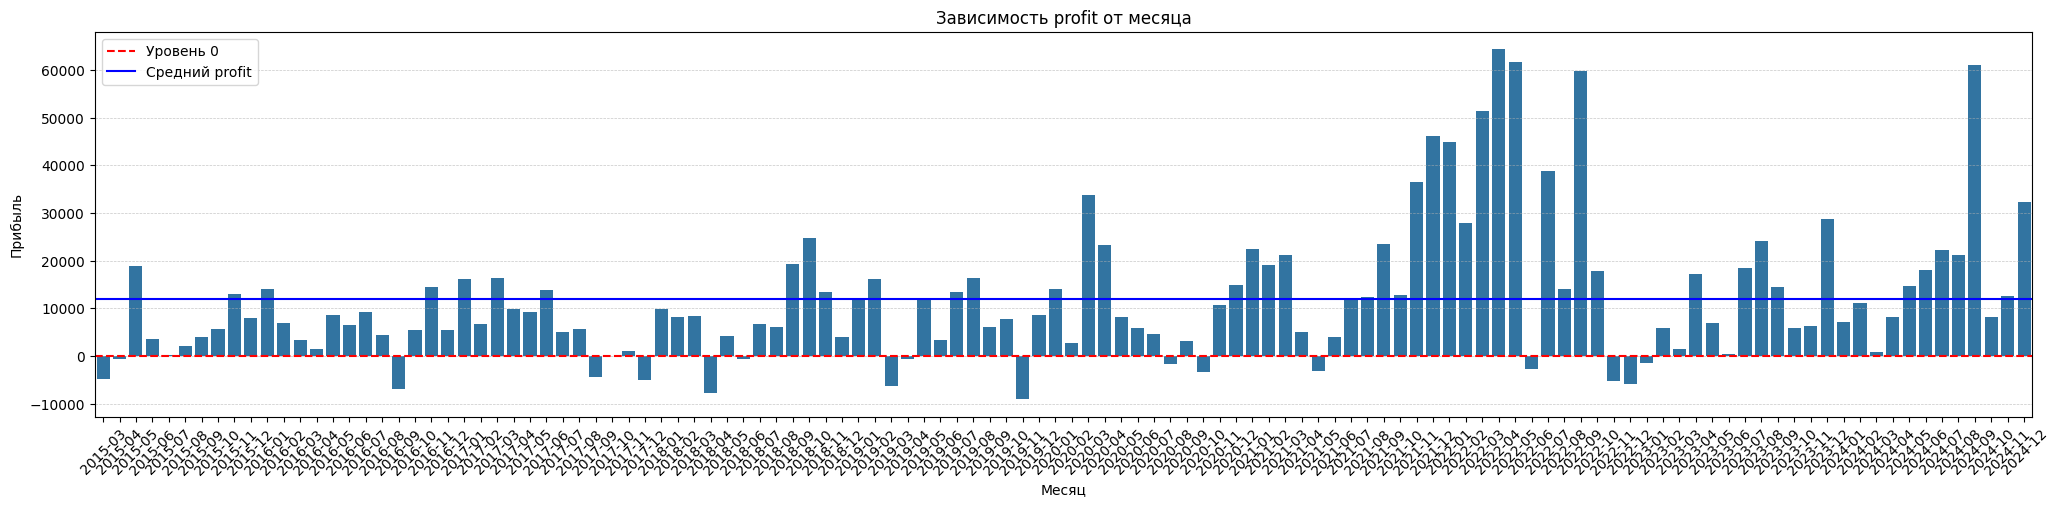

In [127]:
df_month_profit = df_month_profit.sort_values(by='year_month', ascending=True)

# Строим график зависимости
plt.figure(figsize=(25, 5))
sns.barplot(x=df_month_profit['year_month'].astype(str), y=df_month_profit['total_profit'])

# Добавляем горизонтальные линии
plt.axhline(
    y=0, color='red', linestyle='--', linewidth=1.5, label='Уровень 0'
    )  # Пример линии на уровне 0
plt.axhline(
    y=df_month_profit['total_profit'].mean(), color='blue', linestyle='-', linewidth=1.5, 
    label='Средний profit'
    )  # Среднее значение

# Добавляем горизонтальную сетку
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)  # Только по оси Y

plt.xticks(rotation=45)  # Поворачиваем подписи оси X для читаемости
plt.title('Зависимость profit от месяца')
plt.xlabel('Месяц')
plt.ylabel('Прибыль')
plt.legend()  # Добавляем легенду
plt.show()

### График комулятивной прибыли для 2 сессий

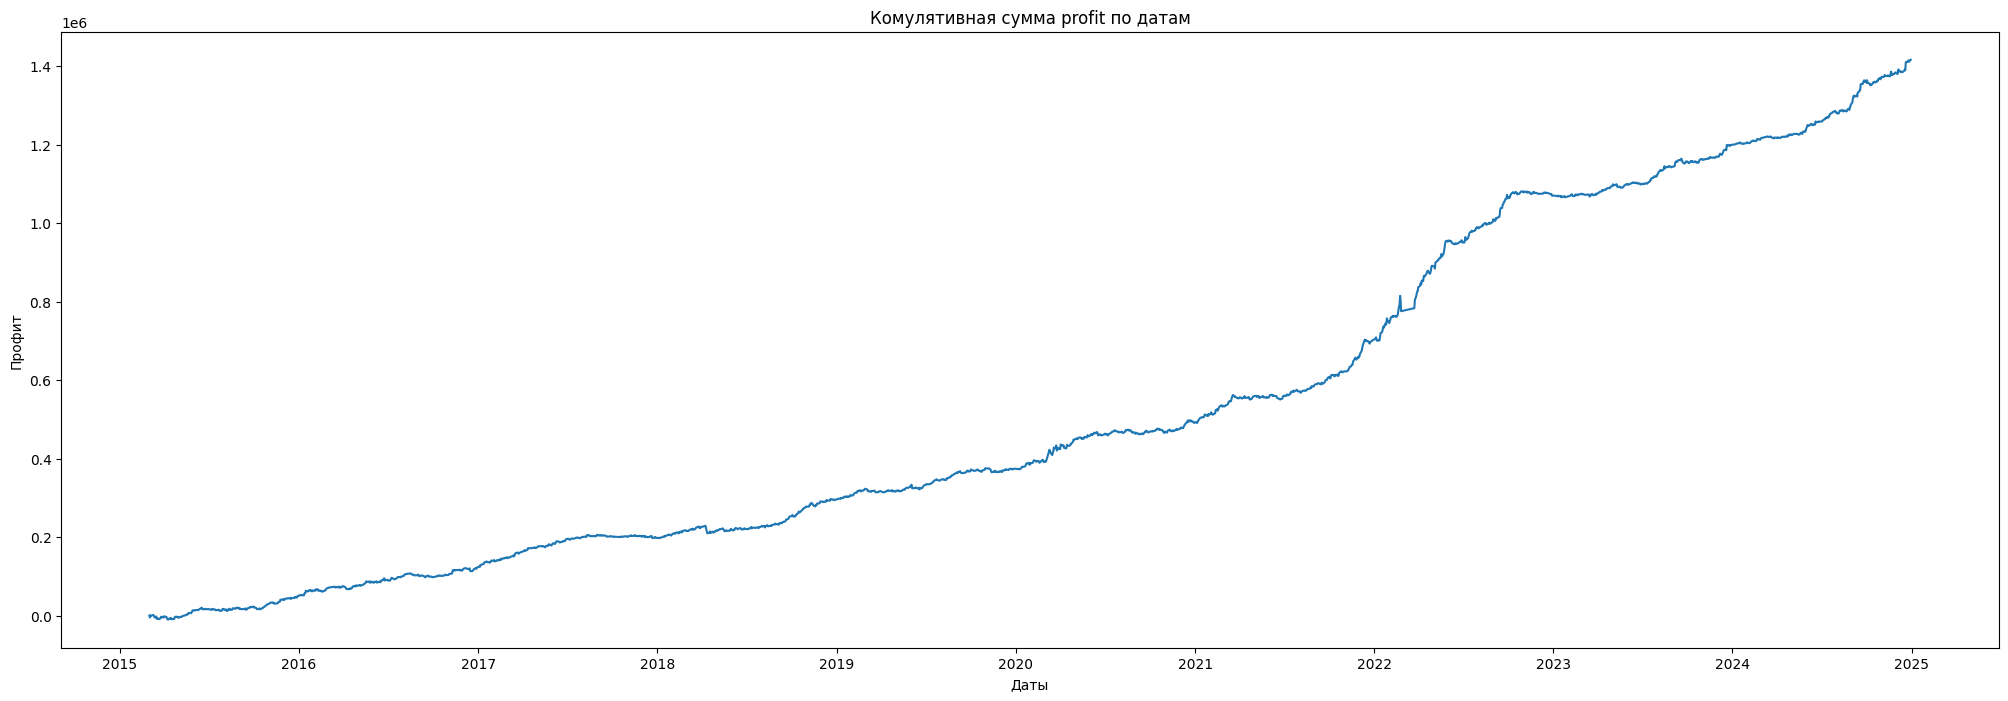

In [128]:
df_2_date['sum_profit'] = df_2_date['total_profit'].cumsum()

plt.figure(figsize=(25, 8))
sns.lineplot(data=df_2_date, x=df_2_date['date'], y='sum_profit')
plt.title('Комулятивная сумма profit по датам')
plt.xlabel('Даты')
plt.ylabel('Профит')
plt.show()

